<a href="https://colab.research.google.com/github/SebastienLiger/Portfolio-Finance/blob/Finance/Trading_Equity_Strategy_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
#import libraries
import pandas_datareader as pdr
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

In [129]:
#define date range
START = datetime.datetime(2000, 1, 3)
END = datetime.datetime(2022, 1, 3)
YEARS = (END - START).days/ 365.25

In [130]:
#define starting variables
STARTING_BALANCE = 1000000
PCT_THRESH = 20

In [131]:
#download data
price = yf.download('^GSPC', START, END)

price.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [132]:
#drop redundant columns
price = price.drop(['Volume', 'Adj Close'], 1)

price.tail()

<ipython-input-132-c564450f4bc6>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)


,Open,High,Low,Close
Date,,,,
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059
2021-12-30,4794.229980,4808.930176,4775.330078,4778.729980
2021-12-31,4775.209961,4786.830078,4765.750000,4766.180176


In [133]:
#calculate benchmark return and balance
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

price.tail()

,Open,High,Low,Close,Return,Bench_Bal
Date,,,,,,
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,1.013839,3.292416e+06
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,0.998990,3.289090e+06
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,1.001402,3.293701e+06
2021-12-30,4794.229980,4808.930176,4775.330078,4778.729980,0.997010,3.283854e+06
2021-12-31,4775.209961,4786.830078,4765.750000,4766.180176,0.997374,3.275230e+06


In [134]:
#calculate benchmark drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

bench_dd

-56.78

In [135]:
#calculate additional columns for strategy

#daily range
price['Range'] = price.High - price.Low
#distance between close and daily low
price['Dist'] = abs(price.Close - price.Low)
#distance as % of range
price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct
Date,,,,,,,,,,,
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,1.013839,3.292416e+06,3.292416e+06,0.000000,57.500000,57.199707,99.477751
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,0.998990,3.289090e+06,3.292416e+06,-3325.850282,26.979980,6.310059,23.387929
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,1.001402,3.293701e+06,3.293701e+06,0.000000,25.979980,14.979980,57.659706
2021-12-30,4794.229980,4808.930176,4775.330078,4778.729980,0.997010,3.283854e+06,3.293701e+06,-9847.362195,33.600098,3.399902,10.118728
2021-12-31,4775.209961,4786.830078,4765.750000,4766.180176,0.997374,3.275230e+06,3.293701e+06,-18471.353715,21.080078,0.430176,2.040675


In [136]:
#identify entries and allocate trading fees
price['Long'] = price.Pct < PCT_THRESH

In [137]:
#calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal
Date,,,,,,,,,,,,,,
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,1.013839,3.292416e+06,3.292416e+06,0.000000,57.500000,57.199707,99.477751,False,1.000000,6.428190e+06
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,0.998990,3.289090e+06,3.292416e+06,-3325.850282,26.979980,6.310059,23.387929,False,1.000000,6.428190e+06
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,1.001402,3.293701e+06,3.293701e+06,0.000000,25.979980,14.979980,57.659706,False,1.000000,6.428190e+06
2021-12-30,4794.229980,4808.930176,4775.330078,4778.729980,0.997010,3.283854e+06,3.293701e+06,-9847.362195,33.600098,3.399902,10.118728,True,1.000000,6.428190e+06
2021-12-31,4775.209961,4786.830078,4765.750000,4766.180176,0.997374,3.275230e+06,3.293701e+06,-18471.353715,21.080078,0.430176,2.040675,True,0.997374,6.411308e+06


In [138]:
#calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

sys_dd

-29.45

In [139]:
#calculate metrics
bench_return = round(((price.Bench_Bal[-1]/price.Bench_Bal[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal[-1]/price.Sys_Bal[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100), 2)
sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')

Benchmark Total return: 227.52%
Benchmark CAGR: 5.54
Benchmark DD: -56.78%

System Total return: 541.13%
System CAGR: 8.81
System DD: -29.45%
Time in Market: 21%
Trades Won: 692
Trades Loss: 474
Winrate: 59.35%


In [140]:
# Utiliser les noms de variables déjà définis
print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'My Portfolio Return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')  # Utiliser sys_win à la place de sys_win_count
print(f'Trades Loss: {sys_loss}')  # Utiliser sys_loss à la place de sys_loss_count
print(f'Winrate: {sys_winrate}%')

# Filtrer les trades gagnants et perdants
winning_trades = price[price.Sys_Ret > 1.0]
losing_trades = price[price.Sys_Ret < 1.0]

# Informations sur les trades gagnants
print("\nWinning Trades:")
for i, row in winning_trades.iterrows():
    print(f"Date: {i}, Return: {round((row['Sys_Ret'] - 1) * 100, 2)}%")

# Informations sur les trades perdants
print("\nLosing Trades:")
for i, row in losing_trades.iterrows():
    print(f"Date: {i}, Return: {round((row['Sys_Ret'] - 1) * 100, 2)}%")

Benchmark Total return: 227.52%
Benchmark CAGR: 5.54
Benchmark DD: -56.78%

My Portfolio Return: 541.13%
System CAGR: 8.81
System DD: -29.45%
Time in Market: 21%
Trades Won: 692
Trades Loss: 474
Winrate: 59.35%

Winning Trades:
Date: 2000-01-05 00:00:00, Return: 0.19%
Date: 2000-01-25 00:00:00, Return: 0.61%
Date: 2000-01-31 00:00:00, Return: 2.52%
Date: 2000-02-10 00:00:00, Return: 0.36%
Date: 2000-02-17 00:00:00, Return: 0.04%
Date: 2000-02-22 00:00:00, Return: 0.45%
Date: 2000-02-28 00:00:00, Return: 1.1%
Date: 2000-03-08 00:00:00, Return: 0.82%
Date: 2000-03-15 00:00:00, Return: 2.43%
Date: 2000-03-29 00:00:00, Return: 0.05%
Date: 2000-04-17 00:00:00, Return: 3.31%
Date: 2000-04-20 00:00:00, Return: 0.5%
Date: 2000-04-27 00:00:00, Return: 0.27%
Date: 2000-05-01 00:00:00, Return: 1.09%
Date: 2000-05-24 00:00:00, Return: 1.83%
Date: 2000-06-07 00:00:00, Return: 0.93%
Date: 2000-06-13 00:00:00, Return: 1.62%
Date: 2000-06-15 00:00:00, Return: 0.56%
Date: 2000-06-19 00:00:00, Return: 1

In [141]:
#define list of ETFs to backtest
symbols = ['^GSPC', '^DJI', '^IXIC', '^FCHI', '^GDAXI']

In [142]:
#create backtesting function
def backtest(symbol):
    #download data
    price = yf.download(symbol, START, END)

    #drop redundant columns
    price = price.drop(['Volume', 'Adj Close'], 1)

    #calculate benchmark return and balance
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

    #calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    #calculate additional columns for strategy
    #daily range
    price['Range'] = price.High - price.Low
    #distance between close and daily low
    price['Dist'] = abs(price.Close - price.Low)
    #distance as % of range
    price['Pct'] = (price.Dist / price.Range) * 100

    #identify entries and allocate trading fees
    price['Long'] = price.Pct < PCT_THRESH

    #calculate system return and balance
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())

    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

    #calculate metrics
    bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

    return bench_cagr, sys_cagr

In [143]:
#backtest multiple symbols
bc = []
sc = []


for symbol in symbols:
    bench_cagr, sys_cagr = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)

[*********************100%%**********************]  1 of 1 completed
<ipython-input-142-cd6e69c9a35a>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)
[*********************100%%**********************]  1 of 1 completed
<ipython-input-142-cd6e69c9a35a>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)
[*********************100%%**********************]  1 of 1 completed
<ipython-input-142-cd6e69c9a35a>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)
[*********************100%%**********************]  1 of 1 completed
<ipython-input-142-cd6e69c9a35a>:7: FutureWarning: In a future version of

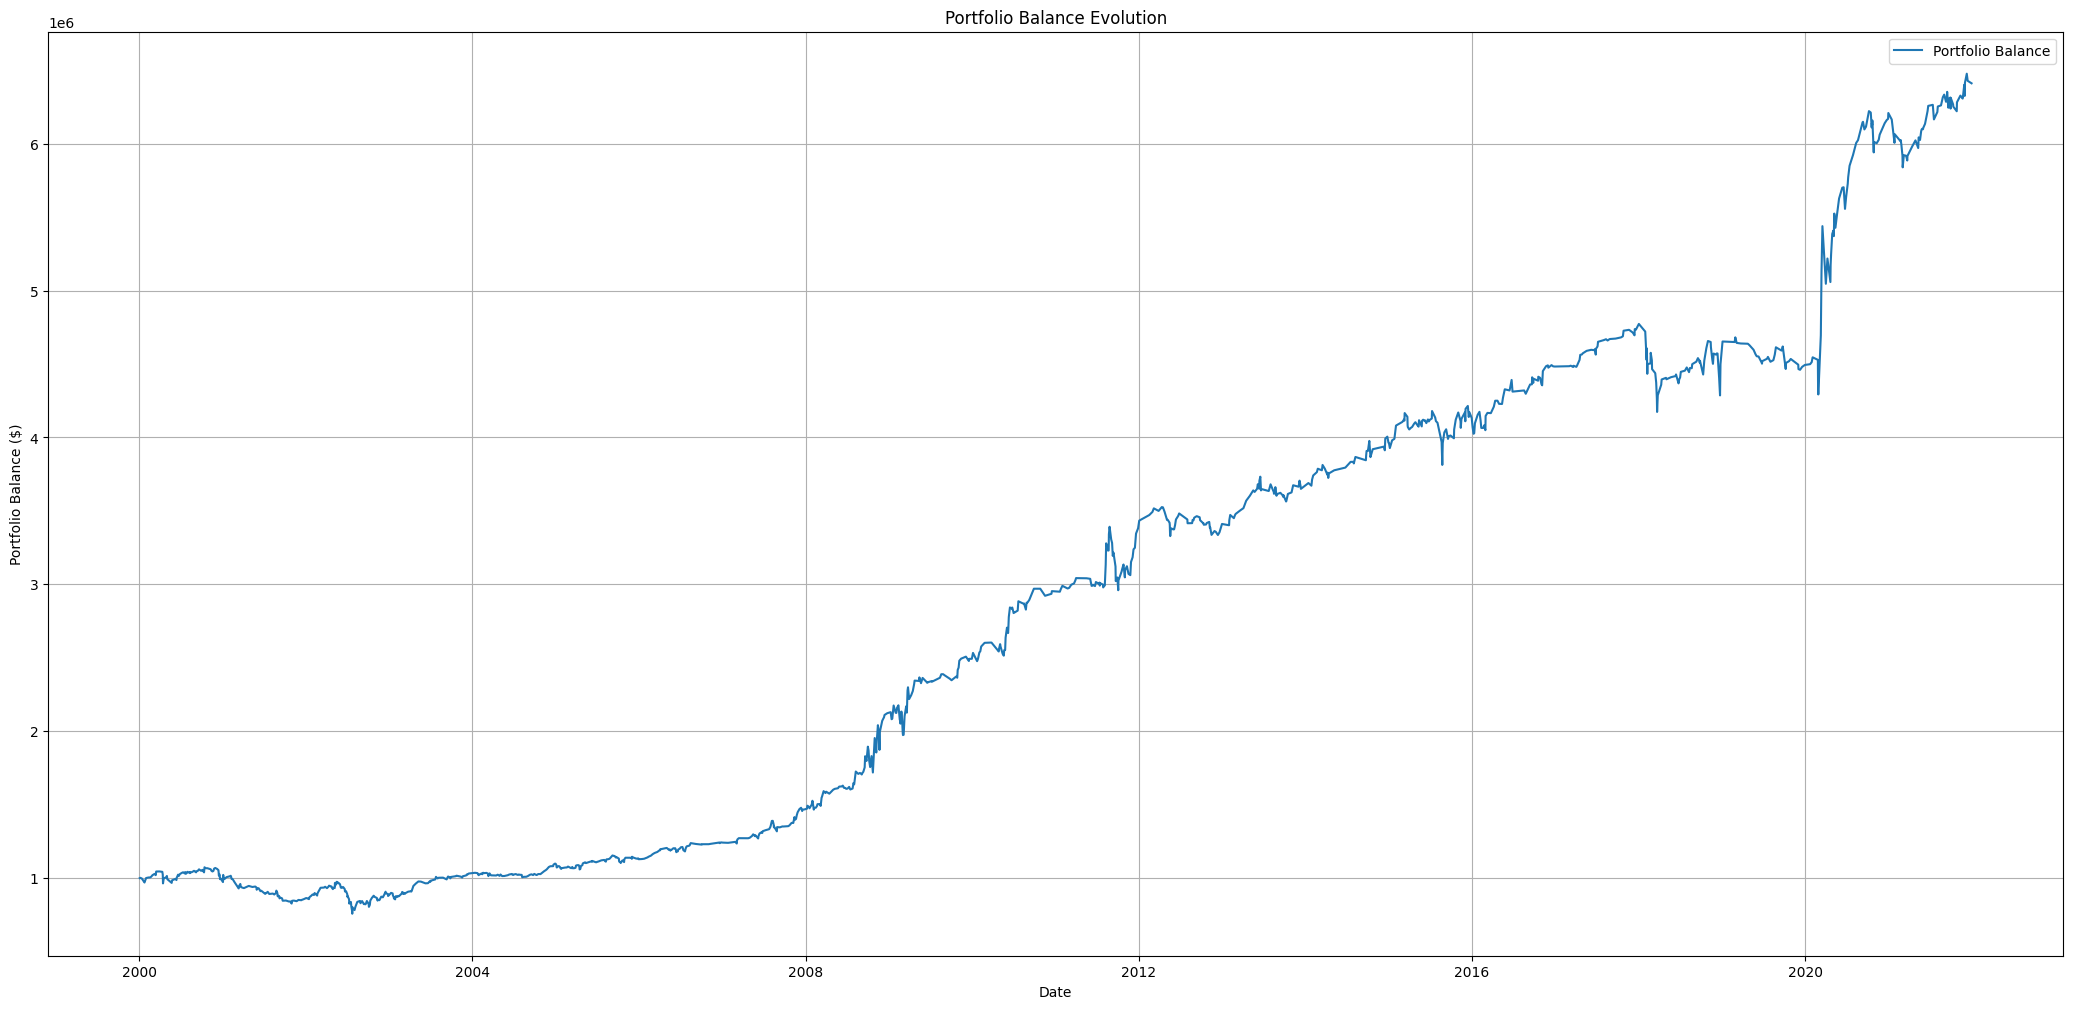

In [144]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine les trades gagnants et perdants en une seule DataFrame
all_trades = pd.concat([winning_trades, losing_trades])

# Trie les trades par date de prise de position
all_trades = all_trades.sort_index()

# Initialisez une variable pour représenter le solde de votre portefeuille
portfolio_balance = STARTING_BALANCE
portfolio_balances = [portfolio_balance]  # Liste pour stocker les soldes du portefeuille à chaque trade
dates = [START]  # Liste pour stocker les dates correspondant à chaque solde du portefeuille

# Parcourez chaque trade et mettez à jour le solde du portefeuille
for i, row in all_trades.iterrows():
    trade_return = (row['Sys_Ret'] - 1) * 100
    portfolio_balance *= 1 + (trade_return / 100)
    portfolio_balances.append(portfolio_balance)
    dates.append(i)

# Créez un graphique avec une courbe représentant l'évolution du solde du portefeuille
plt.figure(figsize=(26, 12))  # Définissez la taille du graphique
plt.plot(dates, portfolio_balances, label='Portfolio Balance')
plt.xlabel('Date')
plt.ylabel('Portfolio Balance ($)')
plt.title('Portfolio Balance Evolution')
plt.legend()
plt.grid(True)
plt.show()

In [145]:
# Liste des symboles des indices à comparer et leurs noms complets
index_symbols = ['^GSPC', '^DJI', '^IXIC', '^FCHI', '^GDAXI']
index_names = ['S&P 500', 'Dow Jones', 'NASDAQ', 'CAC 40', 'DAX']

# Télécharger les données historiques pour chaque indice
index_data = yf.download(index_symbols, start=START, end=END)['Adj Close']

# Renommer les colonnes pour utiliser les noms complets des indices
index_data.columns = index_names

# Formater chaque cellule pour ajouter un espace entre les milliers et les centaines, et pour limiter à deux décimales
formatted_data = index_data.applymap(lambda x: f"{x:,.2f}")
formatted_data

[*********************100%%**********************]  5 of 5 completed


,S&P 500,Dow Jones,NASDAQ,CAC 40,DAX
Date,,,,,
2000-01-03,"11,357.51","5,917.37","6,750.76","1,455.22","4,131.15"
2000-01-04,"10,997.93","5,672.02","6,586.95","1,399.42","3,901.69"
2000-01-05,"11,122.65","5,479.70","6,502.07","1,402.11","3,877.54"
2000-01-06,"11,253.26","5,450.11","6,474.92","1,403.45","3,727.13"
2000-01-07,"11,522.56","5,539.61","6,780.96","1,441.47","3,882.62"
...,...,...,...,...,...
2021-12-27,"36,302.38","7,140.39","15,835.25","4,791.19","15,871.26"
2021-12-28,"36,398.21","7,181.11","15,963.70","4,786.35","15,781.72"
2021-12-29,"36,488.63","7,161.52","15,852.25","4,793.06","15,766.22"


[*********************100%%**********************]  5 of 5 completed


NASDAQ Composite Total return: 278.71%
S&P 500 Total return: 227.52%
Dow Jones Industrial Average Total return: 219.95%
DAX Total return: 135.30%
CAC 40 Total return: 20.88%
My portfolio return: 541.13%


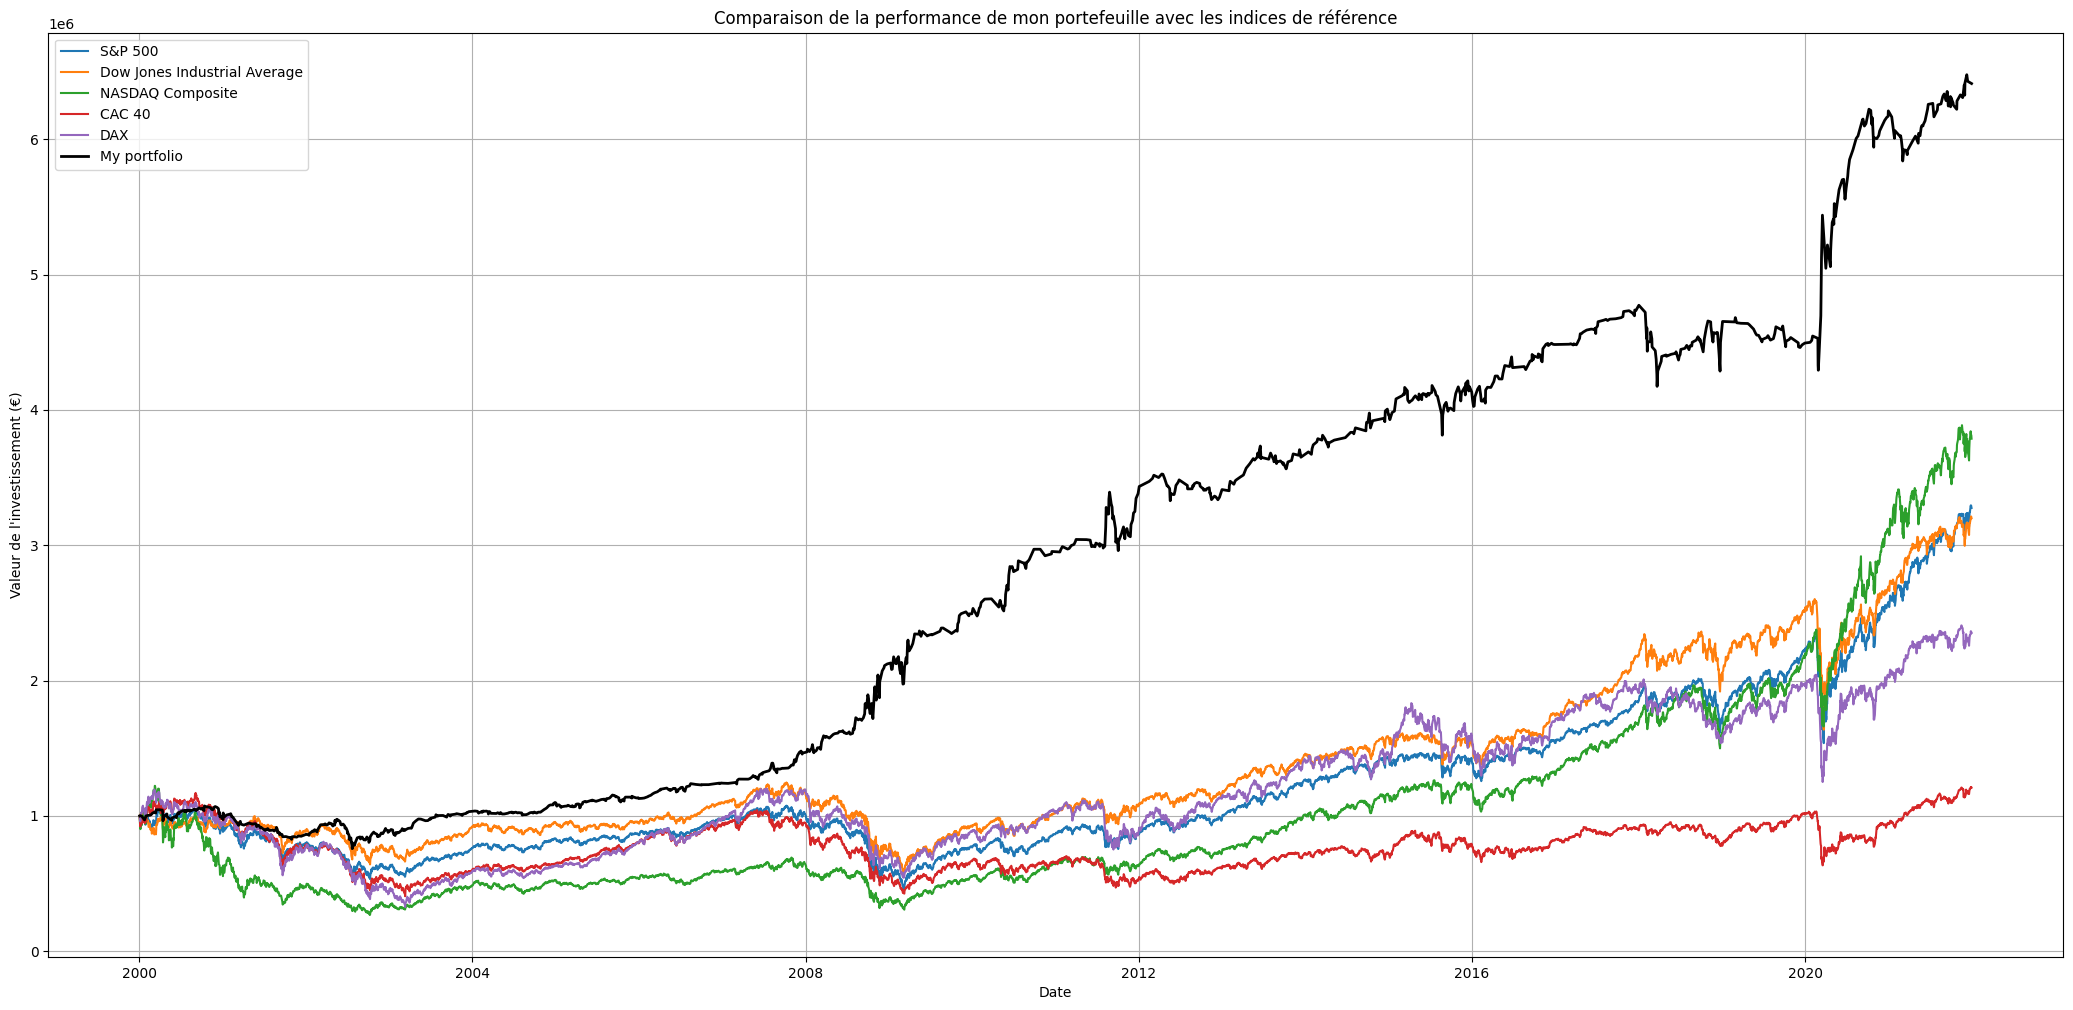

In [146]:
index_names = {
    '^GSPC': 'S&P 500',
    '^DJI': 'Dow Jones Industrial Average',
    '^IXIC': 'NASDAQ Composite',
    '^FCHI': 'CAC 40',
    '^GDAXI': 'DAX'
}

# Téléchargez les données
index_data = yf.download(index_symbols, start=START, end=END)['Adj Close'].ffill()

# Initialisation du montant investi
STARTING_BALANCE = 1000000
investment_amount = STARTING_BALANCE

# Calcul des valeurs des actifs
asset_values = {}
for symbol in index_symbols:
    first_value = index_data[symbol].iloc[0]
    shares_purchased = investment_amount / first_value
    asset_values[symbol] = index_data[symbol] * shares_purchased

# Conversion des valeurs des actifs en DataFrame pour un affichage simplifié
asset_values_df = pd.DataFrame(asset_values)

# Calcul des retours totaux pour chaque indice
total_returns = {}
for symbol in asset_values_df.columns:
    initial_value = asset_values_df[symbol].iloc[0]
    final_value = asset_values_df[symbol].iloc[-1]
    total_return = (final_value - initial_value) / initial_value * 100
    total_returns[symbol] = total_return

# Trier les retours totaux par ordre décroissant de grandeur
sorted_total_returns = sorted(total_returns.items(), key=lambda x: x[1], reverse=True)

# Afficher les retours totaux triés avec les noms complets
for symbol, return_value in sorted_total_returns:
    index_name = index_names.get(symbol, "Unknown Index")
    print(f'{index_name} Total return: {return_value:.2f}%')

print(f'My portfolio return: {sys_return}%')

# Graphique
plt.figure(figsize=(26, 12))
for symbol, values in asset_values.items():
    plt.plot(index_data.index, values, label=index_names[symbol])


# Affichage du portefeuille
plt.plot(dates, portfolio_balances, label='My portfolio', color='black', linewidth=2, linestyle='-')
plt.xlabel('Date')
plt.ylabel('Valeur de l\'investissement (€)')
plt.title('Comparaison de la performance de mon portefeuille avec les indices de référence')
plt.legend()
plt.grid(True)
plt.show()